In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from Bio import SeqIO

In [2]:
data_dir = '../data/raw/GraphProt_CLIP_sequences'

files = os.listdir(data_dir)
print(files)
print(len(files))

['ZC3H7B_Baltz2012.ls.positives.fa', 'ICLIP_HNRNPC.ls.positives.fa', 'PARCLIP_HUR.ls.negatives.fa', 'C22ORF28_Baltz2012.train.negatives.fa', 'PARCLIP_QKI.train.negatives.fa', 'C17ORF85_Baltz2012.ls.negatives.fa', 'PARCLIP_QKI.ls.positives.fa', 'PARCLIP_ELAVL1A.ls.negatives.fa', 'ICLIP_TDP43.train.negatives.fa', 'PARCLIP_HUR.train.negatives.fa', 'ICLIP_TIA1.train.positives.fa', 'CAPRIN1_Baltz2012.ls.positives.fa', 'PTBv1.ls.positives.fa', 'CLIPSEQ_AGO2.ls.positives.fa', 'PARCLIP_EWSR1.ls.negatives.fa', 'PARCLIP_PUM2.ls.negatives.fa', 'CLIPSEQ_ELAVL1.train.negatives.fa', 'ZC3H7B_Baltz2012.train.positives.fa', 'PARCLIP_ELAVL1.ls.negatives.fa', 'PARCLIP_AGO1234.ls.negatives.fa', 'CLIPSEQ_AGO2.train.negatives.fa', 'CLIPSEQ_AGO2.train.positives.fa', 'PARCLIP_AGO1234.ls.positives.fa', 'PARCLIP_ELAVL1.ls.positives.fa', 'PARCLIP_EWSR1.ls.positives.fa', 'ZC3H7B_Baltz2012.train.negatives.fa', 'CLIPSEQ_ELAVL1.train.positives.fa', 'PARCLIP_PUM2.ls.positives.fa', 'CLIPSEQ_AGO2.ls.negatives.fa', 'PTB

### Uploading Data

We can see that there are 96 total files, and that for each dataset there are four files: 
1. ls.positives.fa
2. ls.negatives.fa
3. train.positives.fa
4. train.negatives.fa

We know that the .fa suffix stands for the fasta file format which these sequences are currently in. The sequences in the files labeled "ls" are part of an external dataset that we can use at the end for validation. Until then, we will withold these from training (although we will include them for now so that they will be included at the clustering step (where we will remove sequences with high similarity to avoid redundancy and data leakage). 

This means that there is data for 24 RBPs here. Let's start by opening these files, extracting the sequences and records, and formatting them in a dataframe together. 

We will use SeqIO to read the fasta files. 

### Let's start by deciding which datasets to use
(since we will be training each model for a single RBP, we will pick ~5 of the 24 to use here) 

We will pick datasets based on their size and performance on preivous models. 

In [3]:
print(len('.ls.positives.fa'))
print(len('.ls.negatives.fa'))
print(len('.train.negatives.fa'))
print(len('.train.positives.fa'))

16
16
19
19


In [4]:
RBPs = []
for file in files:
    RBPs.append(file.split('.')[0])
    #print(file.split('.'))
    
distinct_RBPs = [*set(RBPs)]
print(distinct_RBPs)

['PARCLIP_ELAVL1A', 'PARCLIP_FUS', 'PARCLIP_HUR', 'ALKBH5_Baltz2012', 'PARCLIP_AGO1234', 'ZC3H7B_Baltz2012', 'ICLIP_TDP43', 'ICLIP_HNRNPC', 'PARCLIP_QKI', 'ICLIP_TIAL1', 'PTBv1', 'PARCLIP_PUM2', 'CLIPSEQ_AGO2', 'CLIPSEQ_SFRS1', 'CLIPSEQ_ELAVL1', 'C22ORF28_Baltz2012', 'PARCLIP_IGF2BP123', 'ICLIP_TIA1', 'C17ORF85_Baltz2012', 'PARCLIP_TAF15', 'PARCLIP_EWSR1', 'CAPRIN1_Baltz2012', 'PARCLIP_MOV10_Sievers', 'PARCLIP_ELAVL1']


Five datasets to keep: 

1. PARCLIP_AGO1234
2. ICLIP_HNRNPC
3. PARCLIP_ELAVL1A
4. ICLIP_TDP43
5. ICLIP_TIAL1

In [5]:
datasets = ['PARCLIP_AGO1234', 'ICLIP_HNRNPC', 'PARCLIP_ELAVL1', 'ICLIP_TDP43', 'ICLIP_TIAL1']

fasta_files = []
for dataset in datasets:
    fasta_files.append([f'{dataset}.ls.positives.fa', f'{dataset}.ls.negatives.fa', 
                   f'{dataset}.train.negatives.fa', f'{dataset}.train.positives.fa'])

In [6]:
print(fasta_files)

[['PARCLIP_AGO1234.ls.positives.fa', 'PARCLIP_AGO1234.ls.negatives.fa', 'PARCLIP_AGO1234.train.negatives.fa', 'PARCLIP_AGO1234.train.positives.fa'], ['ICLIP_HNRNPC.ls.positives.fa', 'ICLIP_HNRNPC.ls.negatives.fa', 'ICLIP_HNRNPC.train.negatives.fa', 'ICLIP_HNRNPC.train.positives.fa'], ['PARCLIP_ELAVL1.ls.positives.fa', 'PARCLIP_ELAVL1.ls.negatives.fa', 'PARCLIP_ELAVL1.train.negatives.fa', 'PARCLIP_ELAVL1.train.positives.fa'], ['ICLIP_TDP43.ls.positives.fa', 'ICLIP_TDP43.ls.negatives.fa', 'ICLIP_TDP43.train.negatives.fa', 'ICLIP_TDP43.train.positives.fa'], ['ICLIP_TIAL1.ls.positives.fa', 'ICLIP_TIAL1.ls.negatives.fa', 'ICLIP_TIAL1.train.negatives.fa', 'ICLIP_TIAL1.train.positives.fa']]


In [7]:
dataset_dict = {}
for file in fasta_files[0]:
    print(file)
    seq_dict = {}
    for seq_record in SeqIO.parse(f'{data_dir}/{file}', 'fasta'):
        #print(seq_record.id)
        #print(seq_record.seq)
        seq_dict[str(seq_record.id)] = str(seq_record.seq).lower().replace('t', 'u')
    dataset_dict[file] = seq_dict

PARCLIP_AGO1234.ls.positives.fa
PARCLIP_AGO1234.ls.negatives.fa
PARCLIP_AGO1234.train.negatives.fa
PARCLIP_AGO1234.train.positives.fa


In [8]:
ago1234 = pd.DataFrame(dataset_dict)
ago1234.head()

,PARCLIP_AGO1234.ls.positives.fa,PARCLIP_AGO1234.ls.negatives.fa,PARCLIP_AGO1234.train.negatives.fa,PARCLIP_AGO1234.train.positives.fa
"CID_041533;chrX,47028785,47028819,+",gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,NaN,NaN,NaN
"CID_014973;chr15,90774588,90774613,-",guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,NaN,NaN,NaN
"CID_015737;chr16,30959327,30959347,+",ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,NaN,NaN,NaN
"CID_025246;chr2,227661131,227661173,-",ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,NaN,NaN,NaN
"CID_009003;chr12,6347000,6347052,+",gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,NaN,NaN,NaN


In [9]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69212 entries, CID_041533;chrX,47028785,47028819,+ to CID_016143;chr16,70597807,70597847,+
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   PARCLIP_AGO1234.ls.positives.fa     500 non-null    object
 1   PARCLIP_AGO1234.ls.negatives.fa     500 non-null    object
 2   PARCLIP_AGO1234.train.negatives.fa  31310 non-null  object
 3   PARCLIP_AGO1234.train.positives.fa  36902 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB


In [10]:
ago1234.reset_index(inplace=True)

In [11]:
ago1234.columns = ['ID', 'positive_test', 'negative_test', 'negative_train', 'positive_train']

In [12]:
ago1234.head()

,ID,positive_test,negative_test,negative_train,positive_train
0,"CID_041533;chrX,47028785,47028819,+",gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,NaN,NaN,NaN
1,"CID_014973;chr15,90774588,90774613,-",guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,NaN,NaN,NaN
2,"CID_015737;chr16,30959327,30959347,+",ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,NaN,NaN,NaN
3,"CID_025246;chr2,227661131,227661173,-",ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,NaN,NaN,NaN
4,"CID_009003;chr12,6347000,6347052,+",gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,NaN,NaN,NaN


In [13]:
ago1234 = pd.melt(ago1234, id_vars='ID', 
                  value_vars=['positive_test', 'negative_test', 'negative_train', 'positive_train'],
                 var_name = 'sequence_identity', value_name = 'sequence')

In [14]:
ago1234.head()

,ID,sequence_identity,sequence
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...


In [15]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276848 entries, 0 to 276847
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ID                 276848 non-null  object
 1   sequence_identity  276848 non-null  object
 2   sequence           69212 non-null   object
dtypes: object(3)
memory usage: 6.3+ MB


In [16]:
ago1234 = ago1234.dropna(subset='sequence')

In [17]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69212 entries, 0 to 276847
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 69212 non-null  object
 1   sequence_identity  69212 non-null  object
 2   sequence           69212 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


### dataset prep

Now that we have looked into formatting a single dataset, let's write a function that will allow us to do this again automatically for following datasets. 

In [18]:
def format_df_from_fastas(data_dir, dataset_fastas):
    ## first we will move all seqs/ids into a dictionary 
    dataset_dict = {}
    for file in dataset_fastas:
        #print(file)
        seq_dict = {}
        for seq_record in SeqIO.parse(f'{data_dir}/{file}', 'fasta'):
            #print(seq_record.id)
            #print(seq_record.seq)
            seq_dict[str(seq_record.id)] = str(seq_record.seq).lower().replace('t', 'u')
        dataset_dict[file] = seq_dict
        
    df = pd.DataFrame(dataset_dict)
    df.reset_index(inplace=True)
    #now we are renaming columns -- we know that they will always be in this order because I wrote fasta_files
    #list explicitly so that they would be
    df.columns = ['ID', 'positive_test', 'negative_test', 'negative_train', 'positive_train']
    df = pd.melt(df, id_vars='ID', 
                  value_vars=['positive_test', 'negative_test', 'negative_train', 'positive_train'],
                 var_name = 'sequence_identity', value_name = 'sequence')
    #we can drop all rows that have missing values because rows with no sequences are no use to us
    df = df.dropna(subset='sequence')
    return df

In [19]:
hnrnpc = format_df_from_fastas(data_dir, fasta_files[1])

In [20]:
hnrnpc.head()

,ID,sequence_identity,sequence
0,"cid_24084;chrX,53680075,53680107,-",positive_test,ugugaggcaauugcuuagcauaguaucuggcacauaaguuaguuca...
1,"cid_6339;chr13,92163497,92163529,+",positive_test,aaauuugaguuuguaguuaaaugauugucucagaagcauuuccuuu...
2,"cid_7047;chr14,32590369,32590406,+",positive_test,uuuuuuuuuuuuuuuuuuuuggagacaggguucucucucuaacacc...
3,"cid_738;chr1,44765193,44765227,-",positive_test,uuugaacauuucucaccuuccuaggcccauuugcuugggccuuucu...
4,"cid_22458;chr8,128991034,128991066,+",positive_test,acaccuggcuaauuuuuuugugguuuuaguagagaugagguuucac...


In [21]:
hnrnpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42266 entries, 0 to 169063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 42266 non-null  object
 1   sequence_identity  42266 non-null  object
 2   sequence           42266 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [22]:
hnrnpc['seq_len'] = [len(seq) for seq in hnrnpc['sequence']]

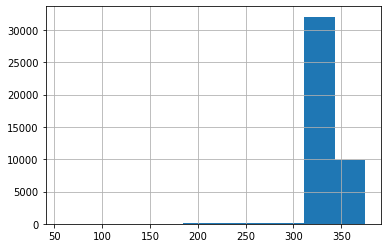

In [23]:
hnrnpc.seq_len.hist()
plt.show()

In [24]:
elavl1a = format_df_from_fastas(data_dir, fasta_files[2])
elavl1a.head()

,ID,sequence_identity,sequence
0,"CID_002575;chr1,156283921,156283954,-",positive_test,cuuucaugauuuccuugauuggcucugucauaaauccuacgaaguc...
1,"CID_005459;chr10,96368133,96368162,+",positive_test,guuugaggauaaaugaggucuaaagacaguaugaacuuguuaauaa...
2,"CID_030395;chr5,145493419,145493445,-",positive_test,ucagaaccuuaggcuggaccuaaauagauugauuucauuucuaacc...
3,"CID_009617;chr12,98941568,98941613,+",positive_test,aggagucuuuuucaucuaaauauguuccuaaguauguucccuuggc...
4,"CID_035058;chr8,614716,614750,-",positive_test,caaauauucagaauugagccacuguguugccauacugauuauguaa...


In [25]:
elavl1a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52249 entries, 0 to 208995
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 52249 non-null  object
 1   sequence_identity  52249 non-null  object
 2   sequence           52249 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [26]:
tdp43 = format_df_from_fastas(data_dir, fasta_files[3])
tdp43.head()

,ID,sequence_identity,sequence
0,"cid_42757;chr17,3597959,3598005,-",positive_test,cccuggccuucccacaguguaauuauugggcuuauuugggggauca...
1,"cid_97060;chr7,11110307,11110352,+",positive_test,auuugggcauauuuucuucuuccuucuaagccuacaucaguauuua...
2,"cid_65845;chr20,42339963,42340033,+",positive_test,aggcuguugaucucugagcuucuguuucuaccugcuuaaaaugacg...
3,"cid_91509;chr6,19568120,19568156,-",positive_test,auaaauuugcuugcuuauagcuguuuucccccuagaaaguaagcuc...
4,"cid_17170;chr11,19797628,19797682,+",positive_test,ucugaaaggaaaucaaguccugaaagguuuagguagggugacaagu...


In [27]:
tdp43.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168109 entries, 0 to 672435
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ID                 168109 non-null  object
 1   sequence_identity  168109 non-null  object
 2   sequence           168109 non-null  object
dtypes: object(3)
memory usage: 5.1+ MB


In [28]:
tial1 = format_df_from_fastas(data_dir, fasta_files[4])
tial1.head()

,ID,sequence_identity,sequence
0,"cid_822;chr1,31501807,31501871,-",positive_test,auuaaauuaaaaaguaugagaaauagcuaacauaauucucaugaug...
1,"cid_8722;chr11,61919476,61919533,+",positive_test,auaucuucaagaagagcaagccccgcuaucacaagcgcaccagcuc...
2,"cid_25818;chr2,96858720,96858758,-",positive_test,auuucuuuaguauccaauguacucacgggauuauguuuauguucgg...
3,"cid_47473;chr8,138917864,138917895,+",positive_test,uugauuuuucuguuuagagaaaugaggacaaaaacaugaacuuaau...
4,"cid_15287;chr14,53385787,53385854,-",positive_test,uuggaccuuagauaaguaugguauucaggcagaugcuaagcuucag...


In [29]:
tial1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79984 entries, 0 to 319935
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 79984 non-null  object
 1   sequence_identity  79984 non-null  object
 2   sequence           79984 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


We can see that the five datasets are all very large. 
It is important to avoid data leakage that we remove sequences with greater than 80% sequence similarity. We will perform this with cd-hit-est and reimport the sequences. 

In [30]:
#five dataframes:
    #ago1234
    #hnrnpc
    #elavl1a
    #tdp43
    #tial1

In [31]:
def write_seqs_to_file(ids, seqs, filename):
    lines = []
    for seq_id, seq in zip(ids, seqs):
        lines.append(f'>{seq_id} \n')
        lines.append(f'{seq} \n')
        lines.append('\n')
    with open(filename, 'w') as f:
        f.writelines(lines)

In [32]:
dataframes = [ago1234, hnrnpc, elavl1a, tdp43, tial1]
names = ['ago1234', 'hnrnpc', 'elavl1a', 'tdp43', 'tial1']
for df, name in zip(dataframes, names):
    write_seqs_to_file(df['ID'].to_list(), df['sequence'].to_list(), 
                   f'../data/intermediate/{name}.fasta')

In [33]:
#for ago1234, the longest sequence is 375 and the shortest is 61
#could use a global CNN with eternafold punpaired predictions since eternafold can handle a window size of 375
#or can divide into windows of size 100

Now I will add more descriptive rows. 

ago1234.head()

In [34]:
#now I want to take the column 'sequence_identity' and use it to create another column which answers 
#binarily whether or not the RNA sequence is a binding one 

In [35]:
rbp_binding = []
for index,row in ago1234.iterrows():
    seq_identity = row['sequence_identity'].split('_')
    if seq_identity[0] == 'positive':
        rbp_binding.append(1)
    elif seq_identity[0] == 'negative':
        rbp_binding.append(0)
    else:
        print('error')
    #print(seq_identity[0])

In [36]:
ago1234['RBP_binding'] = rbp_binding

In [37]:
ago1234.head()

,ID,sequence_identity,sequence,RBP_binding
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,1
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,1
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,1
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,1
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,1


In [38]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69212 entries, 0 to 276847
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 69212 non-null  object
 1   sequence_identity  69212 non-null  object
 2   sequence           69212 non-null  object
 3   RBP_binding        69212 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


In [39]:
ago1234['seq_len'] = [len(seq) for seq in ago1234['sequence']]

In [40]:
ago1234.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,1,334
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,1,325
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,1,320
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,1,342
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,1,352


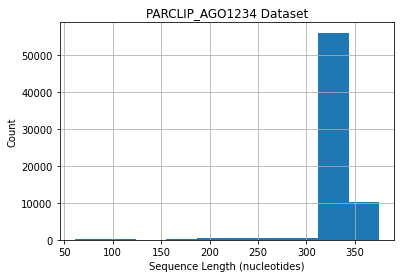

In [41]:
ago1234.seq_len.hist()
plt.xlabel('Sequence Length (nucleotides)')
plt.ylabel('Count')
plt.title('PARCLIP_AGO1234 Dataset')
plt.show()

In [42]:
ago1234.RBP_binding.value_counts()

1    37402
0    31810
Name: RBP_binding, dtype: int64

There seem to be roughly equal numbers of sequences that bind/do not bind. This makes sense with what we know. 
Let's now repeat these operations with the other dataframes. 

In [43]:
def add_rbp_binding_col(df):
    rbp_binding = []
    for index,row in df.iterrows():
        seq_identity = row['sequence_identity'].split('_')
        if seq_identity[0] == 'positive':
            rbp_binding.append(1)
        elif seq_identity[0] == 'negative':
            rbp_binding.append(0)
        else:
            print('error')
    df['RBP_binding'] = rbp_binding
    return df
    #print(seq_identity[0])

In [44]:
#five dataframes:
    #ago1234
    #hnrnpc
    #elavl1a
    #tdp43
    #tial1

In [45]:
hnrnpc = add_rbp_binding_col(hnrnpc)
hnrnpc['seq_len'] = [len(seq) for seq in hnrnpc['sequence']]

In [46]:
hnrnpc.head()

,ID,sequence_identity,sequence,seq_len,RBP_binding
0,"cid_24084;chrX,53680075,53680107,-",positive_test,ugugaggcaauugcuuagcauaguaucuggcacauaaguuaguuca...,332,1
1,"cid_6339;chr13,92163497,92163529,+",positive_test,aaauuugaguuuguaguuaaaugauugucucagaagcauuuccuuu...,332,1
2,"cid_7047;chr14,32590369,32590406,+",positive_test,uuuuuuuuuuuuuuuuuuuuggagacaggguucucucucuaacacc...,337,1
3,"cid_738;chr1,44765193,44765227,-",positive_test,uuugaacauuucucaccuuccuaggcccauuugcuugggccuuucu...,334,1
4,"cid_22458;chr8,128991034,128991066,+",positive_test,acaccuggcuaauuuuuuugugguuuuaguagagaugagguuucac...,332,1


In [47]:
hnrnpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42266 entries, 0 to 169063
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 42266 non-null  object
 1   sequence_identity  42266 non-null  object
 2   sequence           42266 non-null  object
 3   seq_len            42266 non-null  int64 
 4   RBP_binding        42266 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


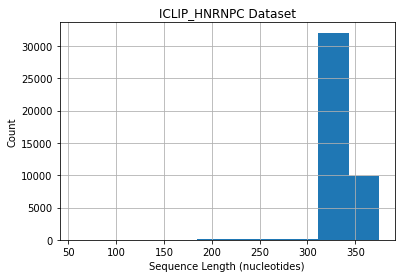

In [48]:
hnrnpc.seq_len.hist()
plt.xlabel('Sequence Length (nucleotides)')
plt.ylabel('Count')
plt.title('ICLIP_HNRNPC Dataset')
plt.show()

In [49]:
hnrnpc.RBP_binding.value_counts()

1    21972
0    20294
Name: RBP_binding, dtype: int64

In [50]:
elavl1a = add_rbp_binding_col(elavl1a)
elavl1a['seq_len'] = [len(seq) for seq in elavl1a['sequence']]

In [51]:
elavl1a.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len
0,"CID_002575;chr1,156283921,156283954,-",positive_test,cuuucaugauuuccuugauuggcucugucauaaauccuacgaaguc...,1,333
1,"CID_005459;chr10,96368133,96368162,+",positive_test,guuugaggauaaaugaggucuaaagacaguaugaacuuguuaauaa...,1,329
2,"CID_030395;chr5,145493419,145493445,-",positive_test,ucagaaccuuaggcuggaccuaaauagauugauuucauuucuaacc...,1,326
3,"CID_009617;chr12,98941568,98941613,+",positive_test,aggagucuuuuucaucuaaauauguuccuaaguauguucccuuggc...,1,345
4,"CID_035058;chr8,614716,614750,-",positive_test,caaauauucagaauugagccacuguguugccauacugauuauguaa...,1,334


In [52]:
elavl1a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52249 entries, 0 to 208995
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 52249 non-null  object
 1   sequence_identity  52249 non-null  object
 2   sequence           52249 non-null  object
 3   RBP_binding        52249 non-null  int64 
 4   seq_len            52249 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


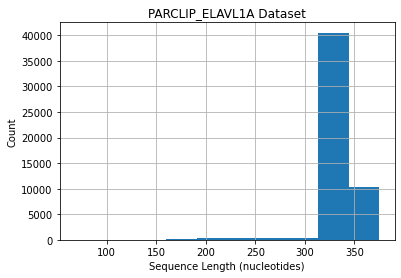

In [53]:
elavl1a.seq_len.hist()
plt.xlabel('Sequence Length (nucleotides)')
plt.ylabel('Count')
plt.title('PARCLIP_ELAVL1A Dataset')
plt.show()

In [54]:
elavl1a.RBP_binding.value_counts()

1    27775
0    24474
Name: RBP_binding, dtype: int64

In [55]:
tdp43 = add_rbp_binding_col(tdp43)
tdp43['seq_len'] = [len(seq) for seq in tdp43['sequence']]

In [56]:
tdp43.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len
0,"cid_42757;chr17,3597959,3598005,-",positive_test,cccuggccuucccacaguguaauuauugggcuuauuugggggauca...,1,346
1,"cid_97060;chr7,11110307,11110352,+",positive_test,auuugggcauauuuucuucuuccuucuaagccuacaucaguauuua...,1,345
2,"cid_65845;chr20,42339963,42340033,+",positive_test,aggcuguugaucucugagcuucuguuucuaccugcuuaaaaugacg...,1,370
3,"cid_91509;chr6,19568120,19568156,-",positive_test,auaaauuugcuugcuuauagcuguuuucccccuagaaaguaagcuc...,1,336
4,"cid_17170;chr11,19797628,19797682,+",positive_test,ucugaaaggaaaucaaguccugaaagguuuagguagggugacaagu...,1,354


In [57]:
tdp43.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168109 entries, 0 to 672435
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ID                 168109 non-null  object
 1   sequence_identity  168109 non-null  object
 2   sequence           168109 non-null  object
 3   RBP_binding        168109 non-null  int64 
 4   seq_len            168109 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.7+ MB


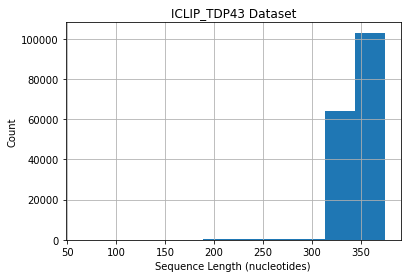

In [58]:
tdp43.seq_len.hist()
plt.xlabel('Sequence Length (nucleotides)')
plt.ylabel('Count')
plt.title('ICLIP_TDP43 Dataset')
plt.show()

In [59]:
tdp43.RBP_binding.value_counts()

1    92530
0    75579
Name: RBP_binding, dtype: int64

In [60]:
tial1 = add_rbp_binding_col(tial1)
tial1['seq_len'] = [len(seq) for seq in tial1['sequence']]

In [61]:
tial1.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len
0,"cid_822;chr1,31501807,31501871,-",positive_test,auuaaauuaaaaaguaugagaaauagcuaacauaauucucaugaug...,1,364
1,"cid_8722;chr11,61919476,61919533,+",positive_test,auaucuucaagaagagcaagccccgcuaucacaagcgcaccagcuc...,1,357
2,"cid_25818;chr2,96858720,96858758,-",positive_test,auuucuuuaguauccaauguacucacgggauuauguuuauguucgg...,1,338
3,"cid_47473;chr8,138917864,138917895,+",positive_test,uugauuuuucuguuuagagaaaugaggacaaaaacaugaacuuaau...,1,331
4,"cid_15287;chr14,53385787,53385854,-",positive_test,uuggaccuuagauaaguaugguauucaggcagaugcuaagcuucag...,1,367


In [62]:
tial1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79984 entries, 0 to 319935
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 79984 non-null  object
 1   sequence_identity  79984 non-null  object
 2   sequence           79984 non-null  object
 3   RBP_binding        79984 non-null  int64 
 4   seq_len            79984 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.7+ MB


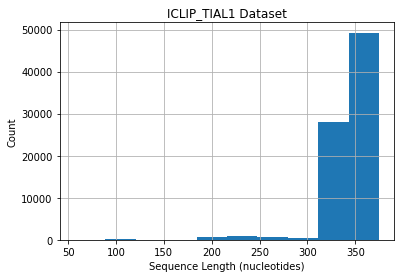

In [63]:
tial1.seq_len.hist()
plt.xlabel('Sequence Length (nucleotides)')
plt.ylabel('Count')
plt.title('ICLIP_TIAL1 Dataset')
plt.show()

In [64]:
tial1.RBP_binding.value_counts()

1    42832
0    37152
Name: RBP_binding, dtype: int64

In [65]:
#five dataframes:
    #ago1234
    #hnrnpc
    #elavl1a
    #tdp43
    #tial1

In [66]:
ago1234.to_csv('../data/intermediate/ago1234.csv')

In [67]:
hnrnpc.to_csv('../data/intermediate/hnrnpc.csv')

In [68]:
elavl1a.to_csv('../data/intermediate/elavl1a.csv')

In [69]:
tdp43.to_csv('../data/intermediate/tdp43.csv')

In [70]:
tial1.to_csv('../data/intermediate/tial1.csv')

Using the file ago1234.fasta, I removed sequences with greater than 80% sequence similarity using the program cd-hit-est. I ran this program in the terminal using the following command: 

                    cd-hit-est -i <input.fasta> -o <output.fasta> -c 0.8 -n 5
                    
This output the file ago1234_clustered.fasta which contains the desired sequences with those with high similarity removed. 

Exact command for AGO1234 dataset can be found in the scripts directory in the main repo (cd-hit-est.command)

I repeated this with the other four fasta files as well. 

Now let's filter our csv's by the sequences in the output file. 

In [71]:
#here I am defining a function to get the dissimilar sequences and filter each dataframe by them 
def get_dissimilar_seqs(fasta_file, df):
    seq_ids = []
    for seq_record in SeqIO.parse(f'{fasta_file}', 'fasta'):
        seq_ids.append(str(seq_record.id))
        
    print(len(seq_ids))
    
    df = df[df['ID'].isin(seq_ids)]
    return df

In [72]:
ago1234 = get_dissimilar_seqs('../data/intermediate/ago1234_clustered.fasta', ago1234)

63118


In [73]:
ago1234.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63118 entries, 0 to 276846
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 63118 non-null  object
 1   sequence_identity  63118 non-null  object
 2   sequence           63118 non-null  object
 3   RBP_binding        63118 non-null  int64 
 4   seq_len            63118 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.9+ MB


In [74]:
ago1234.RBP_binding.value_counts()

1    33560
0    29558
Name: RBP_binding, dtype: int64

In [75]:
hnrnpc = get_dissimilar_seqs('../data/intermediate/hnrnpc_clustered.fasta', hnrnpc)
hnrnpc.info()

39342
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39342 entries, 0 to 169063
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 39342 non-null  object
 1   sequence_identity  39342 non-null  object
 2   sequence           39342 non-null  object
 3   seq_len            39342 non-null  int64 
 4   RBP_binding        39342 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [76]:
hnrnpc.RBP_binding.value_counts()

1    20233
0    19109
Name: RBP_binding, dtype: int64

In [77]:
elavl1a = get_dissimilar_seqs('../data/intermediate/elavl1a_clustered.fasta', elavl1a)
elavl1a.info()

48623
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48623 entries, 0 to 208995
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 48623 non-null  object
 1   sequence_identity  48623 non-null  object
 2   sequence           48623 non-null  object
 3   RBP_binding        48623 non-null  int64 
 4   seq_len            48623 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ MB


In [78]:
elavl1a.RBP_binding.value_counts()

1    25681
0    22942
Name: RBP_binding, dtype: int64

In [79]:
tial1 = get_dissimilar_seqs('../data/intermediate/tial1_clustered.fasta', tial1)
tial1.info()

73715
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73715 entries, 0 to 319934
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 73715 non-null  object
 1   sequence_identity  73715 non-null  object
 2   sequence           73715 non-null  object
 3   RBP_binding        73715 non-null  int64 
 4   seq_len            73715 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.4+ MB


In [80]:
tial1.RBP_binding.value_counts()

1    38645
0    35070
Name: RBP_binding, dtype: int64

Now we have successfully constructed and filtered our dataframes so that they contain the sequences that we want to use in our final model in an orderly format. We have also seen that these datasets contain roughly equal numbers of sequences that bind and do not bind the RBP and that the majority of sequence lengths hover somewhere around 350 nucleotides for these datasets. 

In [81]:
ago1234.to_csv('../data/intermediate/ago1234.csv')
hnrnpc.to_csv('../data/intermediate/hnrnpc.csv')
elavl1a.to_csv('../data/intermediate/elavl1a.csv')
tdp43.to_csv('../data/intermediate/tdp43.csv')
tial1.to_csv('../data/intermediate/tial1.csv')

## Summary 

In this data wrangling step, I uploaded a series of fasta files containing sequences that bind and do not bind to a given RNA-binding protein (RBP). In the raw datasets downloaded, there were 24 datasets for RBPs. Since the model will be trained only for one RBP at a time (since they have specific binding preferences), I chose five datasets based off their size and high performance on previously developed models in the literature. 
    1. AGO1234
    2. HNRNPC
    3. ELAVL1A
    4. TPD43
    5. TIAL1
After the initial data wrangling, exploratory data analysis, and feature engineering steps, I will proceed to focus on training/fine-tuning my CNN using a single one of these datasets. The finalized model architecture will then be trained/tested on the other four datasets in order to compare performance across RBPs. 

Each dataset was comprised of four fasta files: two with RNA sequences that bind the RBP (training and testing sequences) and two with RNA sequences that do not bind the RBP (training and testing sequences). Using Biopython's SeqIO module, I read these fasta files and converted the four files into a single dataframe containing rows for the sequence ID, sequence, RBP binding (a 1 indicating that it does bind, a 0 indicating that it does not), and sequence length. 

I then ran all the sequences through the cd-hit-est program on terminal in order to eliminate sequences with greater than 80% sequence identity in order to prevent redundancy in the training and test sets. The dataframes were filtered for these sequences. 

Finally, I took a look at the average sequence length as well as the number of positive and negative sequences in each dataset. Each dataset is well balanced between positive and negative sequences, with roughly equal numbers of both. In terms of sequence length, a large majority of sequences seem to be ~300-350 nucleotides long, although there are a few examples of sequences as short as ~50 nucleotides long. 

In [82]:
ago1234.head()

,ID,sequence_identity,sequence,RBP_binding,seq_len
0,"CID_041533;chrX,47028785,47028819,+",positive_test,gaacacaucaccugggccucuugcaccuuuuagaaagggcaaccuu...,1,334
1,"CID_014973;chr15,90774588,90774613,-",positive_test,guccuguggcguuuguucuccuaggccaaccccuucaaggagcgaa...,1,325
2,"CID_015737;chr16,30959327,30959347,+",positive_test,ccuucccccugacccugacuccuugaacgucacugaaaacggcagc...,1,320
3,"CID_025246;chr2,227661131,227661173,-",positive_test,ugccucaccccaaacccccaguggagagcagcggugguaagcucuu...,1,342
4,"CID_009003;chr12,6347000,6347052,+",positive_test,gacccaugucucucccuuucccucagccuuccuucagaucaaacca...,1,352


In [88]:
#a quick sanity check that there are no non-standard nucleotides in this dataset
def check_for_nonstandard_nucs(df):
    for index,row in df.iterrows():
        seq = row['sequence']
        for char in seq:
            if char != 'a' and char != 'g' and char != 'u' and char != 'c':
                print('error')
                print(char)
                print(seq)
                print(index)

In [89]:
check_for_nonstandard_nucs(ago1234)

In [85]:
check_for_nonstandard_nucs(hnrnpc)

In [86]:
check_for_nonstandard_nucs(elavl1a)

In [87]:
check_for_nonstandard_nucs(tial1)